In [2]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns
from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.7.2
sinfo       0.3.4
-----
MulticoreTSNE       NA
PIL                 8.4.0
adjustText          NA
attr                21.4.0
backcall            0.2.0
boltons             NA
cached_property     1.5.2
cffi                1.14.6
cloudpickle         2.0.0
ctxcore             0.1.1
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.2
decorator           4.4.2
entrypoints         0.3
frozendict   

In [4]:
adata = sc.read( './pySCENIC_out.loom', validate=False)

# drop the embeddings and extra attributes from the obs object
# adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [5]:
sc._utils.sanitize_anndata( adata )
adata

... storing 'subtype' as categorical


AnnData object with n_obs × n_vars = 22883 × 23322
    obs: 'RegulonsAUC', 'nGene', 'nUMI', 'subtype'
    var: 'Regulons'

In [6]:
adata.X

<22883x23322 sparse matrix of type '<class 'numpy.float32'>'
	with 34659397 stored elements in Compressed Sparse Row format>

In [13]:

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [7]:
df_motifs = load_motifs('./reg.csv')

In [8]:
selected_motifs = ['PAX5','TCF3','EBF1','STAT1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

NameError: name 'display_logos' is not defined

In [9]:
# need do scanpy analysis first
sc.set_figure_params(frameon=False, dpi=600, fontsize=10, dpi_save=600)

sc.pl.scatter( adata, basis='highly_variable_genes_UMAP', 
    color=['Louvain_clusters_Scanpy','Celltype_Garnett'],
    title=['HVG - UMAP (Louvain clusters)','HVG - UMAP (Cell type)'],
    alpha=0.8,
    save='_Louvain-celltype.pdf'
    )

sc.pl.scatter( adata, basis='SCENIC_AUC_UMAP', 
    color=['Louvain_clusters_Scanpy','Celltype_Garnett'],
    title=['SCENIC - UMAP (Louvain clusters)','SCENIC - UMAP (Cell type)'], 
    alpha=0.8,
    save='_Louvain-celltype.pdf'
    )

KeyError: 'compute coordinates using visualization tool highly_variable_genes_UMAP first'

In [10]:
lf = lp.connect( './pySCENIC_out.loom', mode='r', validate=False )
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.subtype, index=lf.ca.CellID ),
        # pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        # pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        # pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'subtype',
 # 'ClusterID',
 # 'Louvain_clusters_Scanpy',
 # 'Percent_mito',
 'nGene',
 'nUMI']
lf.close()
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['subtype'] )
rss_cellType

AHCTF1(+)  ARID3A(+)   ARNT(+)   ATF1(+)   ATF2(+)   ATF3(+)  \
B.mem.IGHM+      0.236806   0.234038  0.233105  0.239055  0.232756  0.236250   
B.transition     0.282644   0.246502  0.288862  0.287267  0.282183  0.281428   
B.naive          0.472430   0.350578  0.498417  0.518562  0.512419  0.512596   
B.mem            0.287953   0.280257  0.272281  0.276727  0.265658  0.274539   
B.IFN-response   0.245148   0.230144  0.250167  0.251992  0.251032  0.250669   
B.mem.CXCR3+     0.300449   0.308841  0.288597  0.281943  0.274257  0.286916   
B.mem.CD27-      0.257013   0.241398  0.250614  0.247558  0.255680  0.258034   

                 ATF4(+)   ATF5(+)   ATF6(+)  ATF6B(+)  ...  ZNF616(+)  \
B.mem.IGHM+     0.239655  0.236174  0.227930  0.239097  ...   0.211474   
B.transition    0.286570  0.282153  0.276730  0.286904  ...   0.263059   
B.naive         0.506432  0.504708  0.473198  0.512492  ...   0.394440   
B.mem           0.281734  0.279412  0.250155  0.275919  ...   0.227927   
B.IFN-response  0.247303  0.247449  0.244010  0.252258  ...   0.235167   
B.mem.CXCR3+    0.290235  0.281663  0.243087  0.282336  ...   0.214050   
B.mem.CD27-     0.247631  0.246042  0.219475  0.247353  ...   0.216729   

                ZNF620(+)  ZNF624(+)  ZNF652(+)  ZNF664(+)  ZNF740(+)  \
B.mem.IGHM+      0.213109   0.216318   0.201706   0.232693   0.203605   
B.transition     0.227133   0.311901   0.221545   0.262697   0.216488   
B.naive          0.331653   0.422093   0.281397   0.443179   0.298981   
B.mem            0.228399   0.235737   0.218682   0.265834   0.207243   
B.IFN-response   0.216797   0.250728   0.207919   0.240000   0.214673   
B.mem.CXCR3+     0.209645   0.226089   0.204049   0.269157   0.197430   
B.mem.CD27-      0.205770   0.200881   0.200290   0.226423   0.195811   

                ZNF76(+)  ZNF780B(+)  ZNF84(+)  ZNF91(+)  
B.mem.IGHM+     0.239191    0.194061  0.217431  0.238948  
B.transition    0.284364    0.197177  0.279369  0.287289  
B.naive         0.525069    0.223849  0.409711  0.519422  
B.mem           0.273859    0.202581  0.244335  0.275099  
B.IFN-response  0.252695    0.195600  0.239108  0.252824  
B.mem.CXCR3+    0.272547    0.192411  0.258736  0.280907  
B.mem.CD27-     0.245402    0.190633  0.244625  0.246000  

[7 rows x 245 columns]

In [14]:
auc_mtx

AHCTF1(+)  ARID3A(+)   ARNT(+)   ATF1(+)   ATF2(+)  \
AAACCTGCACCGCTAG-1_1    0.080770   0.144940  0.041509  0.079161  0.029886   
AAACCTGCACTAAGTC-1_1    0.060739   0.120559  0.078148  0.090895  0.055076   
AAACCTGGTCTCTTAT-1_1    0.027196   0.078902  0.043694  0.080625  0.015846   
AAACGGGCACAGATTC-1_1    0.058414   0.044107  0.039348  0.075888  0.017806   
AAACGGGGTTTGTTTC-1_1    0.092396   0.000000  0.034408  0.091781  0.014784   
...                          ...        ...       ...       ...       ...   
TTTGGTTAGCGTGTCC-1_22   0.083686   0.000000  0.053528  0.087826  0.019513   
TTTGGTTGTCTGGAGA-1_22   0.075281   0.110267  0.046164  0.079219  0.044907   
TTTGGTTTCAAAGACA-1_22   0.063084   0.023524  0.058170  0.086059  0.027069   
TTTGGTTTCACCAGGC-1_22   0.065923   0.228988  0.043168  0.094629  0.023818   
TTTGTCAAGGAGTTTA-1_22   0.118773   0.000000  0.051732  0.086346  0.037728   

                        ATF3(+)   ATF4(+)   ATF5(+)   ATF6(+)  ATF6B(+)  ...  \
AAACCTGCACCGCTAG-1_1   0.040901  0.039096  0.047143  0.021672  0.336135  ...   
AAACCTGCACTAAGTC-1_1   0.044413  0.055082  0.035299  0.044630  0.323957  ...   
AAACCTGGTCTCTTAT-1_1   0.039458  0.074866  0.025620  0.029918  0.246026  ...   
AAACGGGCACAGATTC-1_1   0.037162  0.059144  0.044842  0.025696  0.307833  ...   
AAACGGGGTTTGTTTC-1_1   0.039130  0.083281  0.064704  0.000000  0.199943  ...   
...                         ...       ...       ...       ...       ...  ...   
TTTGGTTAGCGTGTCC-1_22  0.045076  0.044507  0.051090  0.000000  0.343168  ...   
TTTGGTTGTCTGGAGA-1_22  0.027291  0.064516  0.069741  0.024871  0.332018  ...   
TTTGGTTTCAAAGACA-1_22  0.047465  0.042198  0.023469  0.000000  0.340709  ...   
TTTGGTTTCACCAGGC-1_22  0.029401  0.068024  0.044189  0.000000  0.257576  ...   
TTTGTCAAGGAGTTTA-1_22  0.040632  0.066070  0.048313  0.017779  0.291138  ...   

                       ZNF616(+)  ZNF620(+)  ZNF624(+)  ZNF652(+)  ZNF664(+)  \
AAACCTGCACCGCTAG-1_1    0.000000   0.000000   0.000000   0.000000   0.000000   
AAACCTGCACTAAGTC-1_1    0.007611   0.002573   0.038422   0.075717   0.038360   
AAACCTGGTCTCTTAT-1_1    0.000000   0.045969   0.021098   0.000000   0.081475   
AAACGGGCACAGATTC-1_1    0.000000   0.000000   0.067581   0.000000   0.015983   
AAACGGGGTTTGTTTC-1_1    0.000000   0.000000   0.014122   0.000000   0.102214   
...                          ...        ...        ...        ...        ...   
TTTGGTTAGCGTGTCC-1_22   0.000000   0.000000   0.083934   0.000000   0.029471   
TTTGGTTGTCTGGAGA-1_22   0.142689   0.000000   0.047742   0.000000   0.051224   
TTTGGTTTCAAAGACA-1_22   0.067217   0.000000   0.026587   0.000000   0.074926   
TTTGGTTTCACCAGGC-1_22   0.000000   0.000000   0.000000   0.000000   0.035085   
TTTGTCAAGGAGTTTA-1_22   0.034305   0.000000   0.020755   0.035898   0.000000   

                       ZNF740(+)  ZNF76(+)  ZNF780B(+)  ZNF84(+)  ZNF91(+)  
AAACCTGCACCGCTAG-1_1    0.038165  0.065736         0.0  0.011650  0.151745  
AAACCTGCACTAAGTC-1_1    0.000000  0.037296         0.0  0.000000  0.125366  
AAACCTGGTCTCTTAT-1_1    0.000000  0.054419         0.0  0.004360  0.148342  
AAACGGGCACAGATTC-1_1    0.040452  0.060655         0.0  0.044240  0.137277  
AAACGGGGTTTGTTTC-1_1    0.000000  0.044752         0.0  0.046098  0.137888  
...                          ...       ...         ...       ...       ...  
TTTGGTTAGCGTGTCC-1_22   0.001286  0.037766         0.0  0.007576  0.121083  
TTTGGTTGTCTGGAGA-1_22   0.000000  0.048864         0.0  0.052887  0.108420  
TTTGGTTTCAAAGACA-1_22   0.000000  0.059983         0.0  0.038951  0.165703  
TTTGGTTTCACCAGGC-1_22   0.000000  0.059901         0.0  0.064394  0.149609  
TTTGTCAAGGAGTTTA-1_22   0.000000  0.045424         0.0  0.056747  0.141123  

[22883 rows x 245 columns]

In [13]:
rss_cellType.loc[:,rss_cellType.columns.str.contains("IRF")]

IRF1(+)   IRF2(+)   IRF3(+)   IRF4(+)   IRF7(+)   IRF8(+)  \
B.mem.IGHM+     0.237798  0.236674  0.238960  0.233650  0.236722  0.236195   
B.transition    0.288349  0.289897  0.286107  0.292134  0.289011  0.289665   
B.naive         0.516151  0.509009  0.512396  0.506646  0.503143  0.519167   
B.mem           0.275633  0.274916  0.278600  0.270458  0.276364  0.271878   
B.IFN-response  0.254681  0.257391  0.251254  0.260647  0.256594  0.262405   
B.mem.CXCR3+    0.284969  0.287044  0.287899  0.286608  0.291828  0.279266   
B.mem.CD27-     0.247271  0.252381  0.250693  0.253209  0.255934  0.241169   

                 IRF9(+)  
B.mem.IGHM+     0.237315  
B.transition    0.288217  
B.naive         0.505245  
B.mem           0.275536  
B.IFN-response  0.257545  
B.mem.CXCR3+    0.288878  
B.mem.CD27-     0.256112

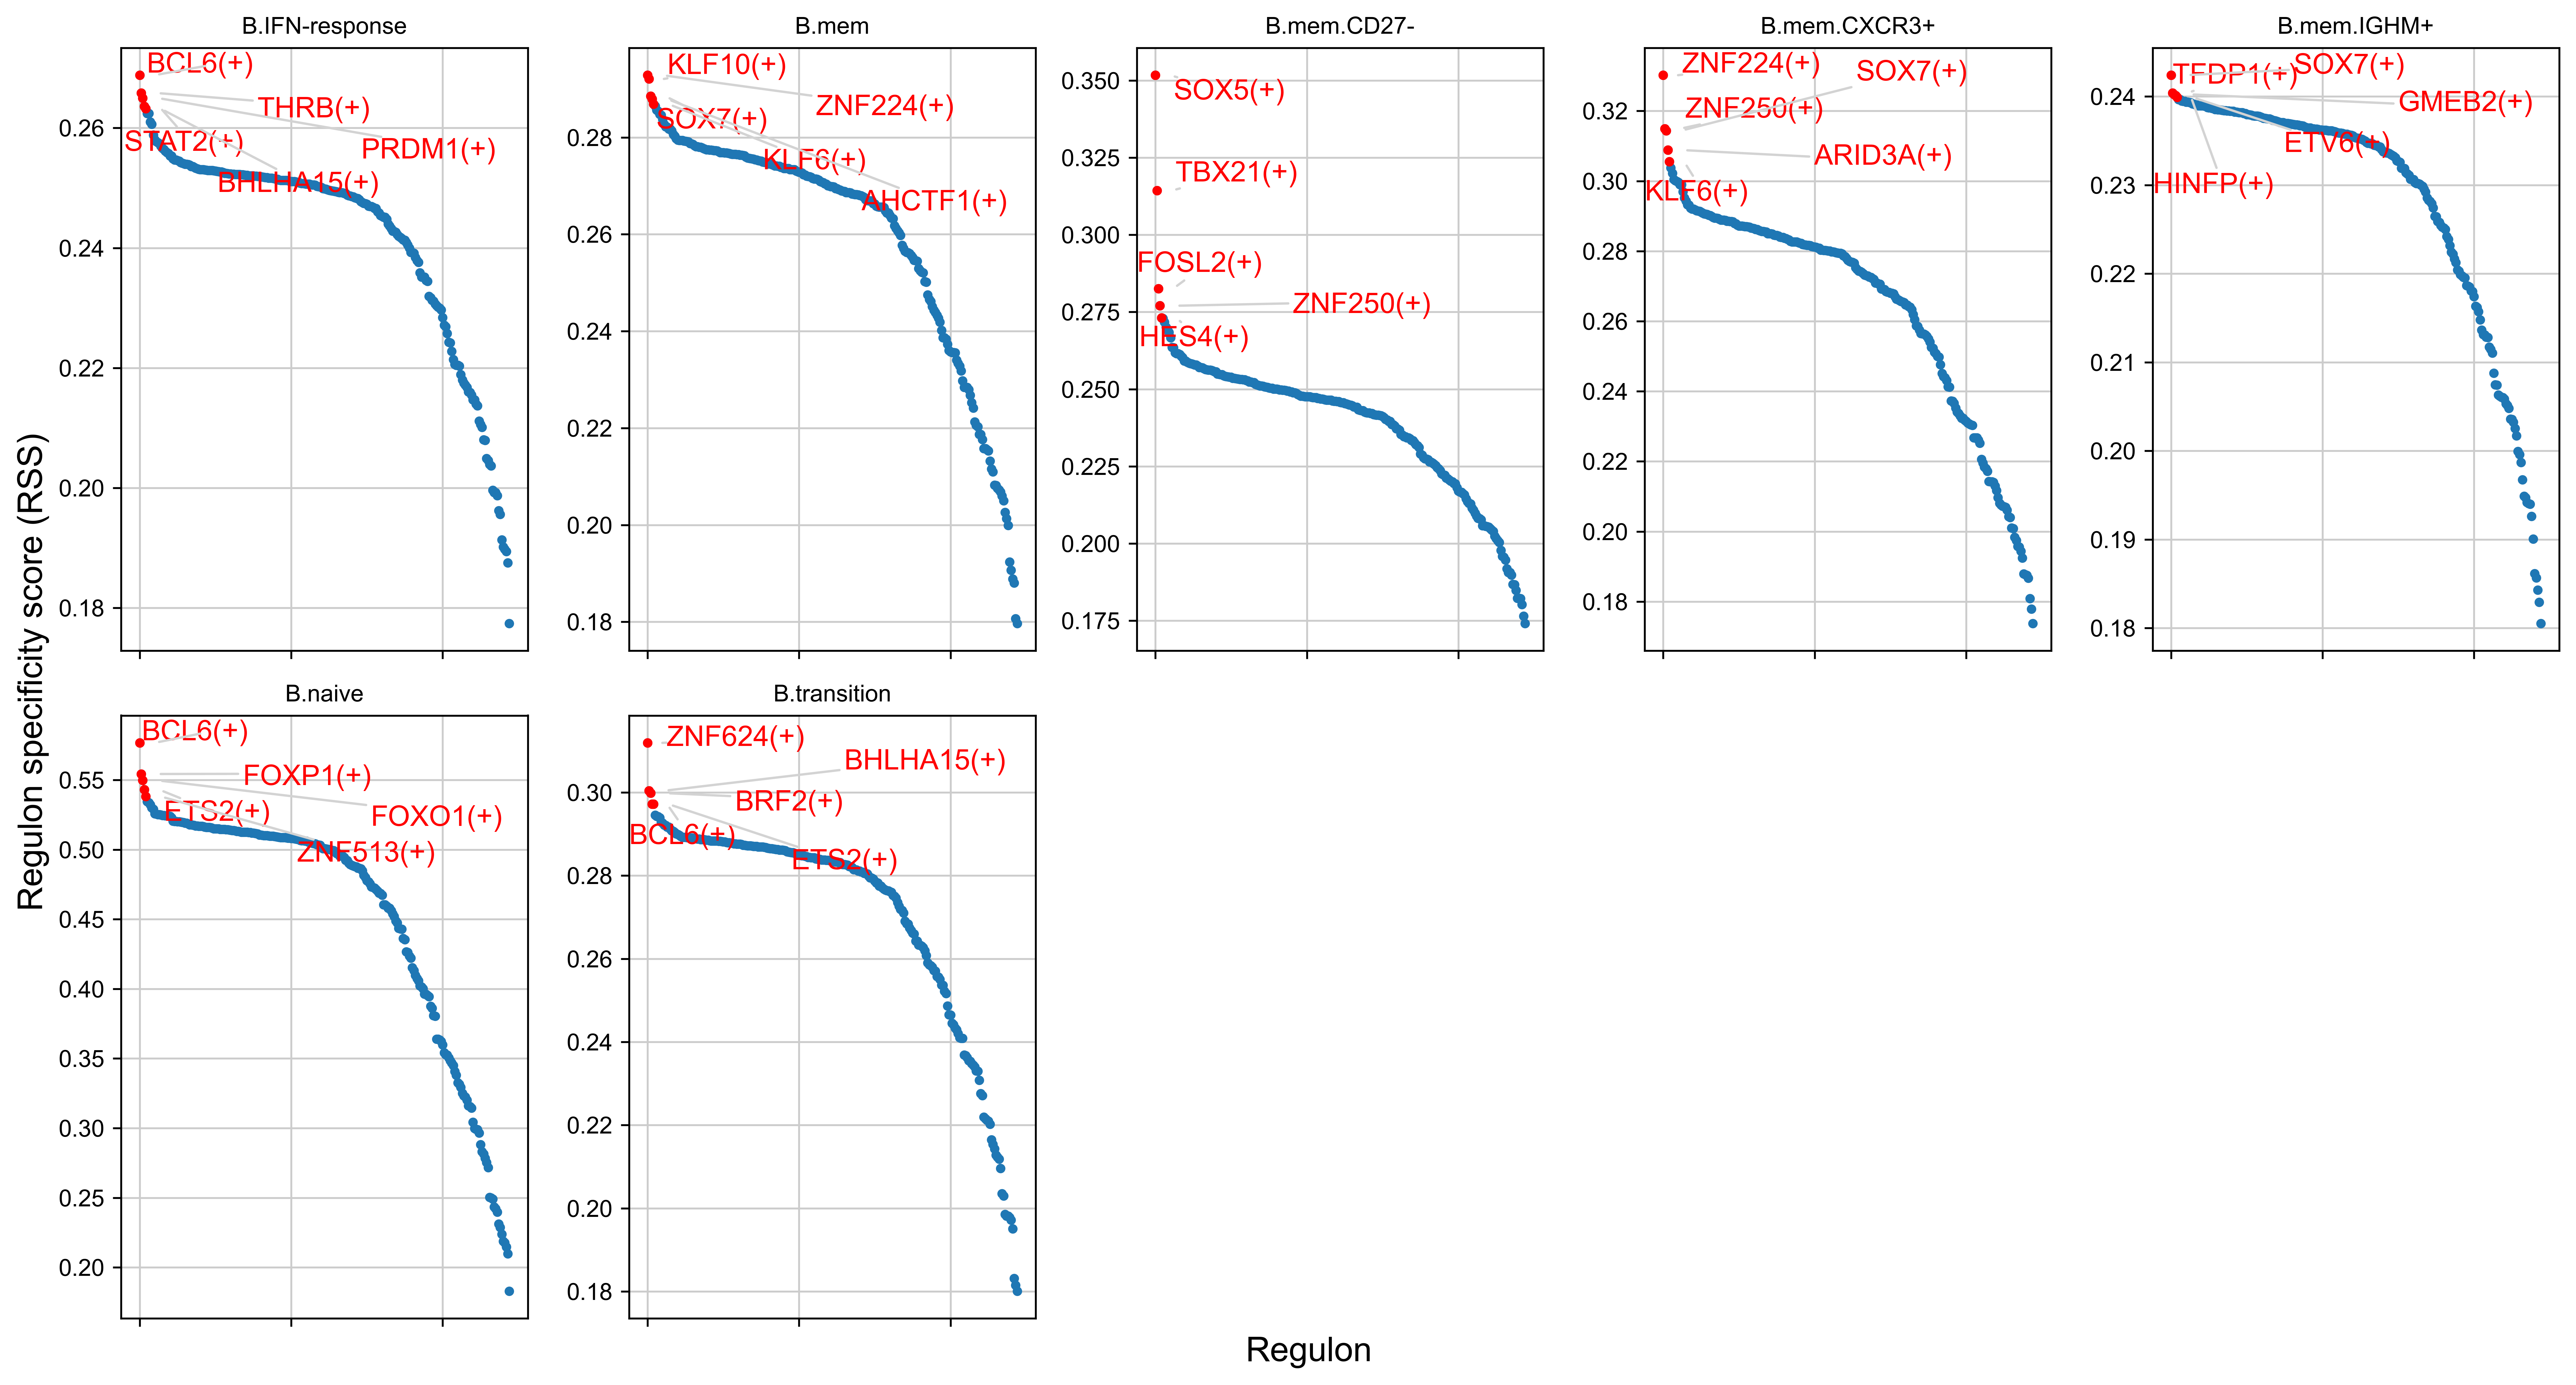

In [30]:
cats = sorted(list(set(cellAnnot['subtype'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [31]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [32]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [33]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [34]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['subtype'] ]

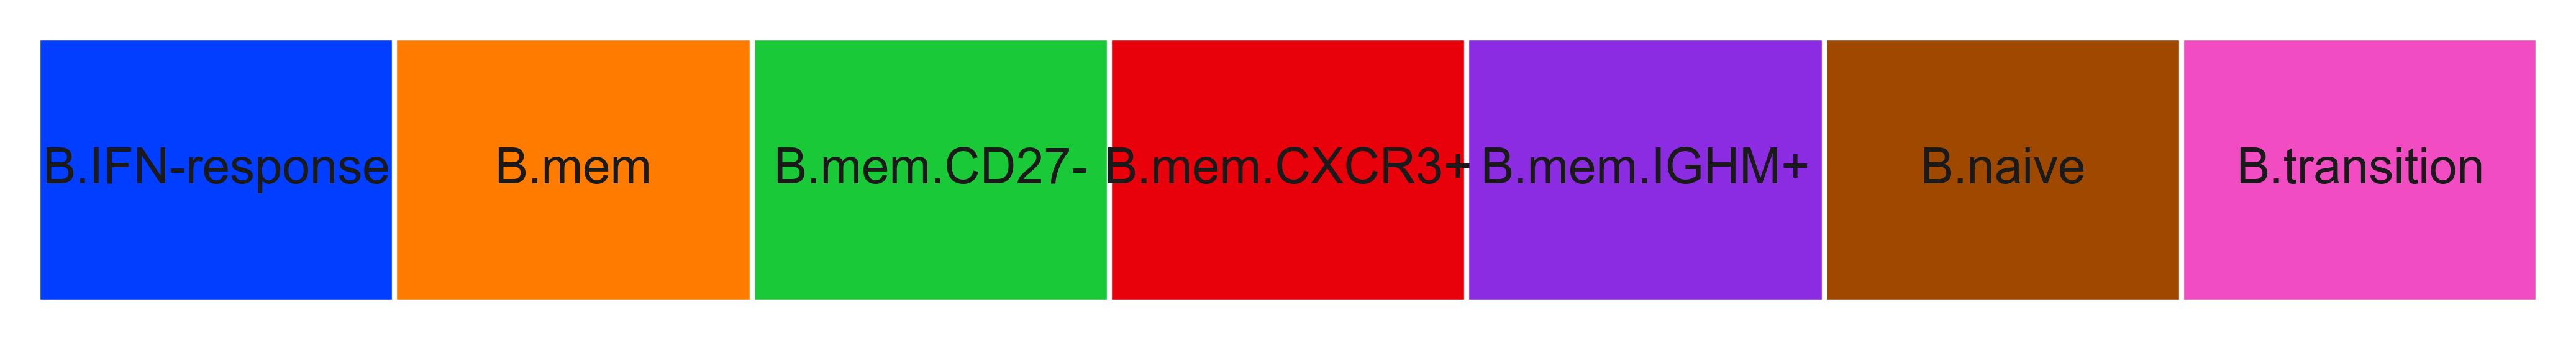

In [35]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

In [36]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

/home/xiacr/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# Further exploration of modules directly from the network inference output

In [47]:
adjacencies = pd.read_csv("./adj.csv", index_col=False)

In [48]:
adjacencies

TF      target    importance
0         KLF2        BTG1  3.046513e+02
1         KLF2        RPS2  2.878068e+02
2         KLF2       PNRC1  2.856504e+02
3         IRF7      IFITM1  2.623211e+02
4         IRF7       ISG15  2.447257e+02
...        ...         ...           ...
4320723  KLF16   WWTR1-AS1  4.972626e-24
4320724   ELF4  AP001107.4  3.942513e-24
4320725    DR1      NANOS3  3.878603e-24
4320726  CEBPB  AL451123.2  2.543937e-24
4320727   UBP1     GLYATL1  2.314009e-24

[4320728 rows x 3 columns]

In [49]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2022-03-05 13:02:55,280 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-03-05 13:02:56,333 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-03-05 13:04:21,395 - pyscenic.utils - INFO - Creating modules.


In [58]:
regulons.keys()

dict_keys(['AHCTF1(+)', 'ARID3A(+)', 'ARNT(+)', 'ATF1(+)', 'ATF2(+)', 'ATF3(+)', 'ATF4(+)', 'ATF5(+)', 'ATF6(+)', 'ATF6B(+)', 'ATF7(+)', 'BACH1(+)', 'BCL6(+)', 'BHLHA15(+)', 'BHLHE40(+)', 'BHLHE41(+)', 'BRF2(+)', 'CEBPB(+)', 'CEBPG(+)', 'CEBPZ(+)', 'CLOCK(+)', 'CREB1(+)', 'CREB3(+)', 'CREB3L2(+)', 'CREB3L4(+)', 'CREB5(+)', 'CREBL2(+)', 'CREBZF(+)', 'CREM(+)', 'CTCF(+)', 'CUX1(+)', 'DBP(+)', 'E2F1(+)', 'E2F3(+)', 'E2F4(+)', 'E2F5(+)', 'E2F6(+)', 'E4F1(+)', 'EGR1(+)', 'EGR2(+)', 'EGR3(+)', 'ELF1(+)', 'ELF2(+)', 'ELF4(+)', 'ELK1(+)', 'ELK3(+)', 'ELK4(+)', 'ERF(+)', 'ESRRA(+)', 'ETS1(+)', 'ETS2(+)', 'ETV2(+)', 'ETV3(+)', 'ETV5(+)', 'ETV6(+)', 'ETV7(+)', 'FLI1(+)', 'FOS(+)', 'FOSB(+)', 'FOSL1(+)', 'FOSL2(+)', 'FOXJ3(+)', 'FOXK1(+)', 'FOXK2(+)', 'FOXN2(+)', 'FOXO1(+)', 'FOXO3(+)', 'FOXP1(+)', 'GABPA(+)', 'GATA1(+)', 'GATA2(+)', 'GATA3(+)', 'GMEB2(+)', 'GTF2B(+)', 'HES4(+)', 'HIC1(+)', 'HINFP(+)', 'HIVEP1(+)', 'HMBOX1(+)', 'HMGA1(+)', 'HOXA10(+)', 'HOXA7(+)', 'HOXA9(+)', 'HSF1(+)', 'HSF2(+)',

In [64]:
tf = 'STAT2'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"(+)"])} genes' )

STAT2 module 0: 2355 genes
STAT2 module 1: 1127 genes
STAT2 module 2: 51 genes
STAT2 module 3: 117 genes
STAT2 module 4: 276 genes
STAT2 module 5: 1774 genes
STAT2 regulon: 1154 genes


In [65]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'(+)']:
        f.write("%s\n" % item)

In [99]:
# regulons['STAT2(+)']
# type(tf_mods[0].gene2weight)
for i in range(0,6):
    print(i)
    tmp  = pd.DataFrame({'gene' : tf_mods[i].genes  ,
                        'weight': tf_mods[i].weights })
    print(tmp[tmp['weight'] > 10].shape)
    tmp =  tmp[tmp['weight'] > 10]
    tmp.to_csv( tf+'_module_'+str(i)+'_filter_10.txt')

0
(92, 2)
1
(92, 2)
2
(50, 2)
3
(35, 2)
4
(76, 2)
5
(92, 2)


In [ ]:
dir()